In [1]:
import os
import math
import numpy as np
import h5py
import glob
from tqdm import tqdm
import scipy

import keras
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Embedding, Input, merge, ELU
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
import sklearn.metrics as metrics

from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
plt.ion()

Using Theano backend.


In [2]:
model_file = 'model_files/sqn_weights.h5'

In [ ]:
W = h5py.File(model_file,'r')
np.array(W['graph']['param_0'])

In [4]:
all_w = []
for i in range(52):
    k = 'param_{0}'.format(i)
    all_w.append(np.array(W['graph'][k]))

In [5]:
W['graph']

<HDF5 group "/graph" (52 members)>

In [ ]:
list(W['graph'].keys())

In [13]:
import models

In [17]:
from trans import get_squeezenet

In [18]:
M = get_squeezenet(10,(64,64))

In [19]:
M

In [20]:
w = M.get_weights()[0]

In [21]:
w.shape

(96, 3, 7, 7)

In [ ]:
W = M.get_weights()
for i in range(52):
    if W[i].shape == all_w[i].shape:
        print(i,W[i].shape,all_w[i].shape)

[That took like two hours to update conda's keras]

In [24]:
M.set_weights?

In [25]:
M.set_weights(all_w)

## Incorporate otto.py

In [30]:
import os
import math
import numpy as np
import h5py
import glob
import scipy
import scipy.misc
import random

import argparse

In [31]:
parser = argparse.ArgumentParser(description='Steer Otto, the autonomous tractor.')
parser.add_argument('-d','--debug', action='store_true', default=False)
parser.add_argument('-n','--no-video', action='store_true', default=False)
parser.add_argument('-f','--failsafe', action='store_true', default=False)

args = parser.parse_args()
debug = args.debug
video = not args.no_video 
failsafe = args.failsafe

usage: __main__.py [-h] [-d] [-n] [-f]
__main__.py: error: unrecognized arguments: /run/user/1000/jupyter/kernel-3f4aabfa-ccad-47d8-a7f9-f669b3cc4fb9.json


SystemExit: 2

/home/franciscodeaqui/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2889: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Add in simplesteer.py

In [32]:
import serial

import keras
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Embedding, Input, merge, ELU
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.regularizers import l2, activity_l2, l1
from keras.utils.np_utils import to_categorical
from keras import backend as K
import sklearn.metrics as metrics

import datetime
import time

cnt = 0


In [33]:
from PIL import Image, ImageDraw
import pygame
import pygame.camera
from pygame.locals import *
pygame.init()
pygame.camera.init()

In [37]:
def backup1(s):
    backup = 35
    if cnt % backup == backup-4:
        s = ','.join(list(map(str,[255,0,100,888888])))
    elif cnt % backup == backup -3:
        s = ','.join(list(map(str,[255,0,100,888888])))
    elif cnt % backup == backup-2:
        s = ','.join(list(map(str,[10,1,1,888888])))
    elif cnt % backup == backup-1:
        s = ','.join(list(map(str,[10,1,55,888888])))
    return s

In [42]:
nrows = 64
ncols = 64
wr = .00001
dp = 0

In [43]:
#M = get_squeezenet_trans((64,64))

In [44]:
W = M.get_weights()
len(W)

54

In [45]:
len(W)

54

In [46]:
W[0].shape

(96, 3, 7, 7)

In [47]:
all_w[0].shape

(96, 3, 7, 7)

In [48]:
M.set_weights(all_w[:-2])

In [49]:
W[-1]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [123]:
# speed, accel, distance, angle
real_in = Input(shape=(2,), name='real_input')

# video frame in, grayscale
frame_in = Input(shape=(3,nrows,ncols), name='img_input')

# convolution for image input
conv1 = Convolution2D(24,5,5,border_mode='same', W_regularizer=l1(wr), init='lecun_uniform')
conv_l1 = conv1(frame_in)
Econv_l1 = ELU()(conv_l1)
pool_l1 = MaxPooling2D(pool_size=(2,2))(Econv_l1)

conv2 = Convolution2D(32,5,5,border_mode='same', W_regularizer=l1(wr), init='lecun_uniform')
conv_l2 = conv2(pool_l1)
Econv_l2 = ELU()(conv_l2)
pool_l2 = MaxPooling2D(pool_size=(2,2))(Econv_l2)
drop_l2 = Dropout(dp)(pool_l2)

conv3 = Convolution2D(40,5,5,border_mode='same', W_regularizer=l1(wr), init='lecun_uniform')
conv_l3 = conv3(drop_l2)
Econv_l3 = ELU()(conv_l3)
pool_l3 = MaxPooling2D(pool_size=(2,2))(Econv_l3)
drop_l3 = Dropout(dp)(pool_l3)

conv4 = Convolution2D(48,5,5,border_mode='same', W_regularizer=l1(wr), init='lecun_uniform')
conv_l4 = conv4(drop_l3)
Econv_l4 = ELU()(conv_l4)
pool_l4 = MaxPooling2D(pool_size=(2,2))(Econv_l4)
drop_l4 = Dropout(dp)(pool_l4)

conv5 = Convolution2D(64,5,5,border_mode='same', W_regularizer=l1(wr), init='lecun_uniform')
conv_l5 = conv5(drop_l4)
Econv_l5 = ELU()(conv_l5)
pool_l5 = MaxPooling2D(pool_size=(2,2))(Econv_l5)
drop_l5 = Dropout(dp)(pool_l5)

flat = Flatten()(drop_l5)

M = merge([flat,real_in], mode='concat', concat_axis=1)

D1 = Dense(256,W_regularizer=l1(wr), init='lecun_uniform')(M)
ED1 = ELU()(D1)
DED1 = Dropout(dp)(ED1)

D2 = Dense(128,W_regularizer=l1(wr), init='lecun_uniform')(DED1)
ED2 = ELU()(D2)
DED2 = Dropout(dp)(ED2)

D3 = Dense(128,W_regularizer=l1(wr), init='lecun_uniform')(DED2)
ED3 = ELU()(D3)
DED3 = Dropout(dp)(ED3)

S1 = Dense(64,W_regularizer=l1(wr), init='lecun_uniform')(DED3)
ES1 = ELU()(S1)

#Steer_node = Dense(1, name='steer_node', init='lecun_uniform')(ES1)
#Steer_out = Activation(clamp,name='steer_out')(Steer_node)
Steer_out = Dense(1, activation='linear', name='steer_out', init='lecun_uniform')(ES1)

model = Model(input=[real_in, frame_in], output=[Steer_out])

sgd = SGD(lr=0.003)
adam = Adam(lr=0.001)


model.compile(loss=['mse'],
              optimizer=adam,
metrics=['mse'])

In [63]:
imgs = np.load('data/imgs_arr.npz')['arr_0']
speedx = np.load('data/speedx_arr.npz')['arr_0']
targets = np.load('data/targets_arr.npz')['arr_0']

In [64]:
nb_epoch = 100
mini_epoch = 5
num_steps = int(nb_epoch/mini_epoch)

In [ ]:
for step in tqdm(range(0,num_steps)):
    h = model.fit([speedx, imgs], {'steer_out':targets[:,0]},
                    batch_size = 32, nb_epoch=mini_epoch, verbose=1,
                    validation_split=0.1, shuffle=True)
    model.save_weights('data/steer_nodrop_l2_big2_fixed_{0}_{1:4.5}.h5'.format(step,h.history['val_loss'][-1]),overwrite=True)


In [66]:
model.save_weights('data/steer_only_l2_big2_final.h5',overwrite=True)
model.load_weights('data/steer_only_l2_big2_final.h5')

In [67]:
W = model.get_weights()

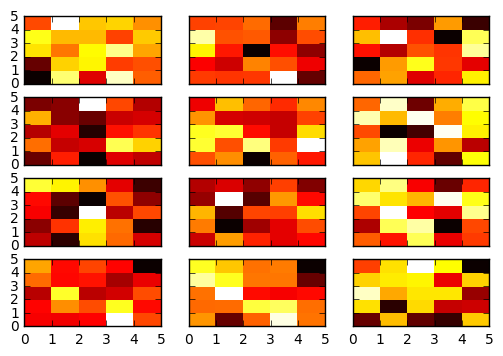

In [70]:
# look at conv filters separately in color channel
f, con = plt.subplots(4,3, sharex='col', sharey='row')
for row in range(4):
    for col in range(3):
        con[row,col].pcolormesh(W[0][row,col],cmap=plt.cm.hot)

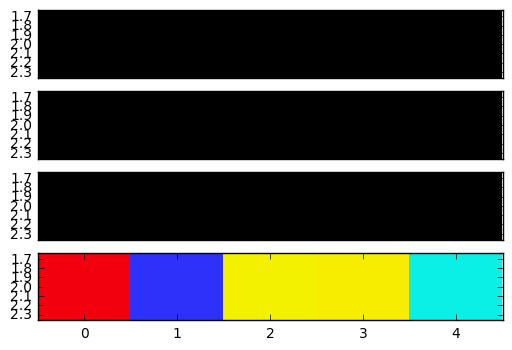

In [71]:
# combine color channels into on filter image
f, con = plt.subplots(4,1, sharex='col', sharey='row')
for row in range(4):
    con[row].imshow(W[0][row].transpose((1,2,0)),
interpolation="none")

In [72]:
preds = model.predict([speedx,imgs])
steer_preds = preds.reshape([-1])

INFO (theano.gof.compilelock): Refreshing lock /home/franciscodeaqui/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.2-64/lock_dir/lock


In [73]:
%matplotlib inline

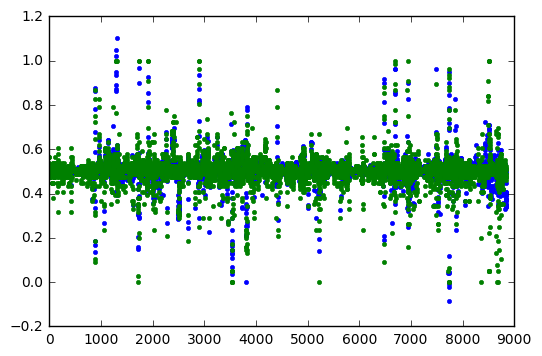

In [74]:
plt.plot(np.array([steer_preds.reshape(len(steer_preds)),targets[:,0]]).T,'.')

In [76]:
def get_point(s,start=0,end=63,height= 16):
    X = int(s*(end-start))
    if X < start:
        X = start
    if X > end:
        X = end
    return (X,height)

In [77]:
mse = []
all_preds = []
weights = sorted(glob.glob('steer_nodrop*.h5'),
        key = lambda x: int(x.split('_')[4]) )
val_idx = (len(imgs)//10) * 9

In [78]:
for wfile in tqdm(weights):
    model.load_weights(wfile)
    preds = model.predict([speedx[val_idx:],imgs[val_idx:]])
    steer_preds = preds.reshape([-1])
    all_preds.append(steer_preds)
    mse.append(metrics.mean_squared_error(targets[val_idx:,0],steer_preds))


0it [00:00, ?it/s]


In [82]:
#plt.plot(np.array([steer_preds.reshape(len(steer_preds)),targets[val_idx:,0]]).T,'.')
#plt.plot(mse)

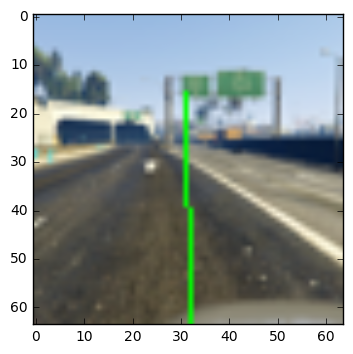

In [84]:
import matplotlib.animation as animation
figure = plt.figure()
imageplot = plt.imshow(np.zeros((64, 64, 3), dtype=np.uint8))
def next_frame(i):
    im = Image.fromarray(np.array(imgs[val_idx+i].transpose(1,2,0),dtype=np.uint8))
    p = get_point(1-steer_preds[i])
    t = get_point(1-targets[i+val_idx,0])
    draw = ImageDraw.Draw(im) 
    draw.line((32,63, p,p),
                fill=(255,0,0,128))
    draw.line((32,63, t,t),
                fill=(0,255,0,128))
    imageplot.set_array(im)
    #if i % 10 == 0:
    #    print(i)
    return imageplot,
animate = animation.FuncAnimation(figure, next_frame, frames=range(0,len(imgs)), interval=25, blit=False)
plt.show()

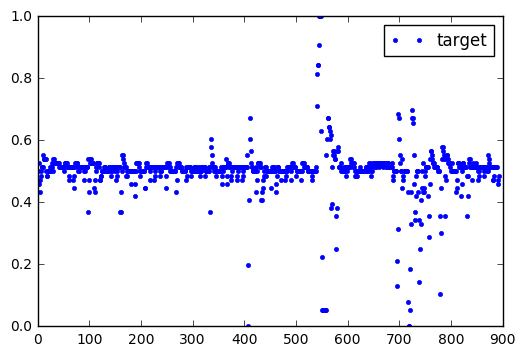

In [85]:
# Muck with default symbol cycler
from itertools import cycle, product
from cycler import cycler
C1 = plt.rcParams['axes.prop_cycle']
C = [c['color'] for c in list(C1)]
sym = [".","x","+","v"]
S1 = cycler('marker',sym)
#P = ['{0}{1}'.format(c,s) for c,s in product(C,sym)]
P = S1*C1
plt.rc('axes', prop_cycle=P)
lines = plt.plot(np.array( [targets[val_idx:,0]] + [sp.reshape(len(steer_preds)) for sp in all_preds]).T, linestyle='')
plt.legend(lines, ['target'] + [str(i) for i in range(len(all_preds))])

## Return to trans.py

In [126]:
from tqdm import tqdm

imgs = np.load('data/imgs_arr_big.npz')['arr_0']
speedx = np.load('data/speedx_arr_big.npz')['arr_0']
targets = np.load('data/targets_arr_big.npz')['arr_0']

In [127]:
nb_epoch = 10
mini_epoch = 1
num_steps = int(nb_epoch/mini_epoch)

In [128]:
import models
from trans, import fire_module, get_squeezenet_trans, get_squeezenet_mini_trans
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

In [133]:
def fire_module(x, squeeze=16, expand=64, trainable = True):
    x = Convolution2D(squeeze, 1, 1, border_mode='valid')(x)
    x = Activation('relu')(x)

    left = Convolution2D(expand, 1, 1, border_mode='valid')(x)
    left = Activation('relu')(left)

    right = ZeroPadding2D(padding=(1, 1))(x)
    right = Convolution2D(expand, 3, 3, border_mode='valid')(right)
    right = Activation('relu')(right)

    y = merge([left, right], mode='concat', concat_axis=1)
    return y
def get_squeezenet_trans( img_size = (64,64)):
    input_img = Input(shape=(3, img_size[0], img_size[1]))
    x = Convolution2D(96, 7, 7, subsample=(2, 2), border_mode='valid', trainable=False)(input_img)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 16, 64)
    x = fire_module(x, 16, 64)
    x = fire_module(x, 32, 128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 32, 128)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 64, 256)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 64, 256)
    x = Dropout(0.5)(x)

    x = ZeroPadding2D(padding=(1, 1))(x)

    # Otto takes over
    # speed, accel, distance, angle
    real_in = Input(shape=(2,), name='real_input')

    flat = Flatten()(x)
    M = merge([flat,real_in], mode='concat', concat_axis=1)
    D1 = Dense(16,W_regularizer=l2(wr), init='lecun_uniform')(M)
    ED1 = ELU()(D1)
    DED1 = Dropout(dp)(ED1)

    S1 = Dense(64,W_regularizer=l2(wr), init='lecun_uniform')(DED1)
    ES1 = ELU()(S1)

    Steer_out = Dense(1, activation='linear', name='steer_out', init='lecun_uniform')(ES1)

    model = Model(input=[real_in, input_img], output=[Steer_out])
    return model

def get_squeezenet_mini_trans( img_size = (64,64)):
    input_img = Input(shape=(3, img_size[0], img_size[1]))
    x = Convolution2D(96, 7, 7, subsample=(2, 2), border_mode='valid')(input_img)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 16, 64)
    x = fire_module(x, 16, 64)
    x = fire_module(x, 32, 128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    # Otto takes over
    # speed, accel, distance, angle
    real_in = Input(shape=(2,), name='real_input')

    flat = Flatten()(x)
    M = merge([flat,real_in], mode='concat', concat_axis=1)
    D1 = Dense(256,W_regularizer=l2(wr), init='lecun_uniform')(M)
    ED1 = ELU()(D1)
    DED1 = Dropout(dp)(ED1)

    S1 = Dense(64,W_regularizer=l2(wr), init='lecun_uniform')(DED1)
    ES1 = ELU()(S1)

    Steer_out = Dense(1, activation='linear', name='steer_out', init='lecun_uniform')(ES1)

    model = Model(input=[real_in, input_img], output=[Steer_out])
    return model

In [134]:
M = get_squeezenet_mini_trans((nrows,ncols)) 
adam = Adam(lr=0.001)
M.compile(loss=['mse'],
              optimizer=adam,
metrics=['mse'])

In [135]:
for step in range(0,num_steps):
    h = M.fit([speedx, imgs], {'steer_out':targets[:,0]},
             batch_size = 32, nb_epoch=mini_epoch, verbose=1,
              validation_split=0.1, shuffle=True)
    model.save_weights('transfer_{0}_{1:4.5}.h5'.format(step,h.history['val_loss'][-1]),overwrite=True)

INFO (theano.gof.compilelock): Refreshing lock /home/franciscodeaqui/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.2-64/lock_dir/lock


Train on 17241 samples, validate on 1916 samples
Epoch 1/1
17241/17241 [==============================] - 250s - loss: 158815.0273 - mean_squared_error: 158814.9777 - val_loss: 0.0286 - val_mean_squared_error: 0.0286
Train on 17241 samples, validate on 1916 samples
Epoch 1/1
17241/17241 [==============================] - 257s - loss: 0.0546 - mean_squared_error: 0.0173 - val_loss: 0.0279 - val_mean_squared_error: 0.0279
Train on 17241 samples, validate on 1916 samples
Epoch 1/1
17241/17241 [==============================] - 292s - loss: 0.0494 - mean_squared_error: 0.0170 - val_loss: 0.0278 - val_mean_squared_error: 0.0278
Train on 17241 samples, validate on 1916 samples
Epoch 1/1
17241/17241 [==============================] - 304s - loss: 0.0469 - mean_squared_error: 0.0167 - val_loss: 0.0285 - val_mean_squared_error: 0.0285
Train on 17241 samples, validate on 1916 samples
Epoch 1/1
17241/17241 [==============================] - 352s - loss: 0.0455 - mean_squared_error: 0.0165 - val_l

KeyboardInterrupt: 